# Use: Tests of `BenamouBrenier.py`

In [105]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
from warnings import warn
from tqdm.notebook import tqdm,trange # to display loading bars
%load_ext autoreload
%autoreload 2

from BenamouBrenier import TransportProblem
from transport import gaussian_transport, gaussian_discreatization, random_gaussian_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
def torus_dist2(x,y):
    dist = np.min([(x[0]-y[0])**2, (1-np.abs(x[0]-y[0]))**2])
    dist = dist + np.min([(x[1]-y[1])**2, (1-np.abs(x[1]-y[1]))**2])
    return dist

d = torus_dist2(np.array([0,0.5]), np.array([0.75,0.5]))
np.sqrt(d)

0.25

## BenamouBrenier.solve

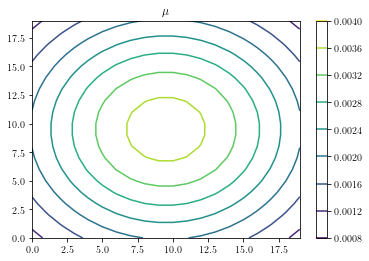

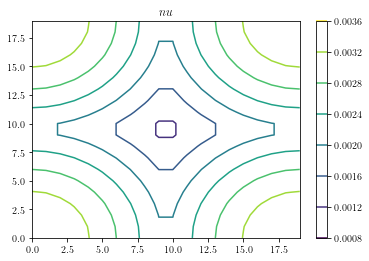

TransportProblem object initialized.


  0%|          | 0/2 [00:00<?, ?it/s]

Poisson step: 7.49445915222168
projection step: 0.38904595375061035
dual step: 0.002148151397705078
Poisson step: 3.9061670303344727
projection step: 0.49825000762939453
dual step: 0.0005629062652587891
Benamou-Brenier method stopped at the maximum number of iterations, with criterium = 894183.2738713416>1e-07


Text(0.5, 1.0, 'criteria')

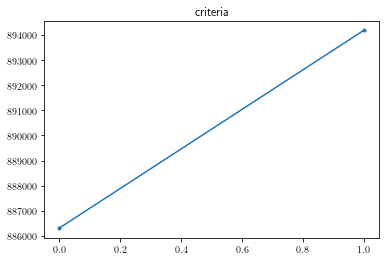

In [126]:
%matplotlib inline
plt.rcParams['text.usetex'] = True

rng = np.random.default_rng(123)
from scipy.stats import multivariate_normal
from matplotlib.widgets import Slider
N=20
T=N
mesh= np.array(np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N)))

#mean1, cov1 = random_gaussian_parameters(2,rng)
#mean2, cov2 = random_gaussian_parameters(2,rng)
sigma = 0.2
mean1 , cov1 = 0.5 * np.ones((2)) , sigma * np.eye(2)
mean2 , cov2 = 1 * np.ones((2)) , sigma * np.eye(2)

mu,nu = np.empty((N,N)),np.empty((N,N))
for idx in np.ndindex((N,N)):
    mu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean1)/sigma)
    nu[idx] = np.exp(-0.5*torus_dist2(mesh[(...,*idx)],mean2)/sigma)
mu = mu/np.sum(mu)
nu = nu/np.sum(nu)

plt.figure()
plt.contour(mu)
plt.colorbar()
plt.title("$\mu$")

plt.figure()
plt.contour(nu)
plt.colorbar()
plt.title("$nu$")
plt.show()

prob1 = TransportProblem(mesh,mu,nu,T,tau=0.1)
criteria = prob1.solve(maxiter=2)
plt.plot(criteria,'.-')
plt.title("criteria")

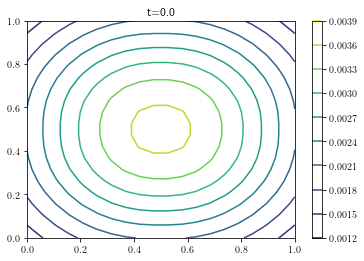

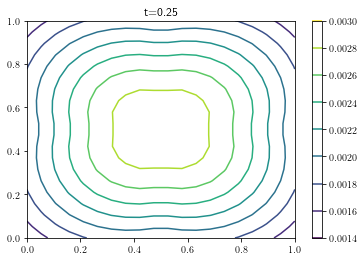

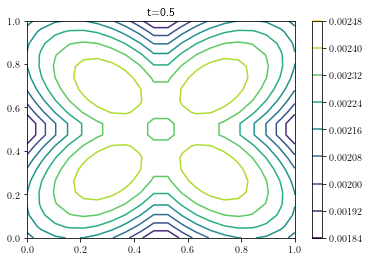

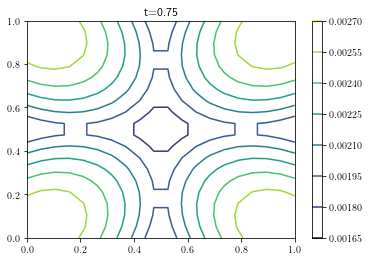

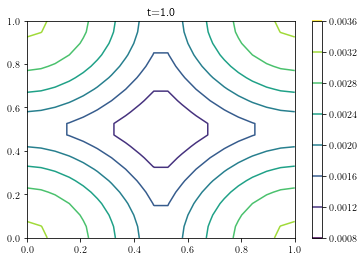

In [122]:
%matplotlib inline
tt= np.linspace(0,1,5)
prob1.plot(tt)

In [66]:
%matplotlib
fig = prob1.plot()

Using matplotlib backend: MacOSX


## Poisson step
- used centered $O(h^2)$ finite difference, with ghost point for Neumann bc
- the source term is a divergence and we need acces to $\nabla\phi$, done with centered $O(h^2)$ finite difference except on the Numann boundary where it is $O(h)$
- System underdetermined, used kernel orthogonality

## Steps
- **Projection Step**:
    - Analytic solution complicated and numerically instable. reduce the problem to 1D (grid-wise), and use Newton method to solve the polynomial equation of orthogonality. [Algorithms for projecting points onto conics](https://www.sciencedirect.com/science/article/pii/S0377042713001398#s000005)
    - choice of the initial point ([desmos graphic](https://www.desmos.com/calculator/nj6gcjfbaq)) to get the right zero.
- **Dual Step**: easy
- **Poisson Step**:
- What is the Domain $\Omega\subset\mathbb{R}^d$, should contain the support of $\mu$ and $\nu$?
- gaussian transport
    - restrict to an ellipsis support of $\mu$ and renormalise (polar coord and 1D normal distribution)
    - the transport map is still optimal and lead to an ellipsis support, and is still optimal.

## 3D Poisson solver
Solver of the 3D poisson equation with mixed boundary condition that are heterogenous Neumann in the first dimension and periodic in the last two ones.

In [33]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
%matplotlib inline
%load_ext autoreload
%autoreload 2

from poisson import *

nn = np.linspace(10,32,5).astype(int)
order = "F"

#uex = lambda x,y,z: -1 + x**2 + np.sin(2*np.pi*y) + np.sin(4*np.pi*z)
#f = lambda x,y,z:  0*x + 2 - (2*np.pi)**2 * np.sin(2*np.pi*y) - (4*np.pi)**2 * np.sin(4*np.pi*z)

uex = lambda x,y,z: x + np.sin(2*np.pi*y) + np.sin(4*np.pi*z)
f = lambda x,y,z:  0*x - (2*np.pi)**2 * np.sin(2*np.pi*y) - (4*np.pi)**2 * np.sin(4*np.pi*z)

err = np.zeros((len(nn),2))
for i,n in enumerate(nn):
    x=np.linspace(0,1,n)[:,None,None]
    y=np.linspace(0,1,n)[None,:,None]
    z=np.linspace(0,1,n)[None,None,:]
    uex_vect = uex(x,y,z)
    f_vect = f(x,y,z)
    g_vect = np.array([np.ones((n,n)), np.ones((n,n))])

    u,A,b,u_vect = poisson(f_vect,g_vect)

    u = u - np.mean(u) + np.mean(uex_vect)
    err[i,0],err[i,1] = np.max(np.abs(u-uex_vect)),np.mean(np.abs(u-uex_vect))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/benoitmuller/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


integral of u:            0.5
integral of uex:          0.5
max-norm of the error:    0.12235801065171059
L1-norm of the error:    0.043917022306790024


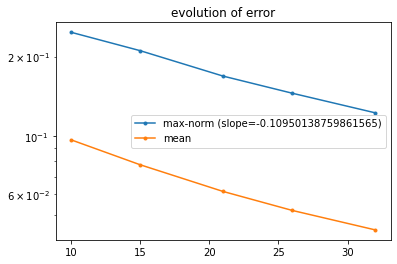

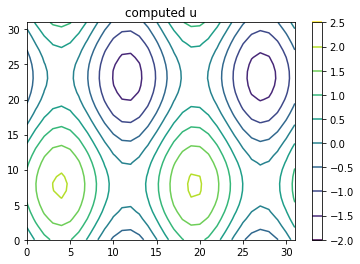

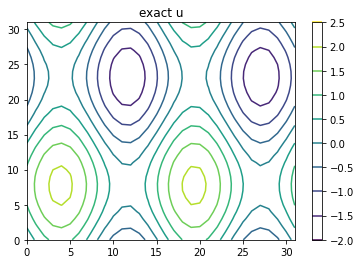

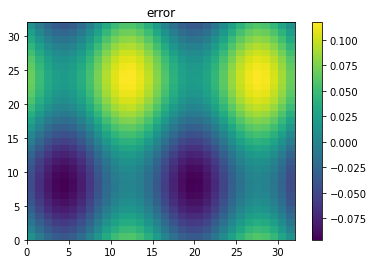

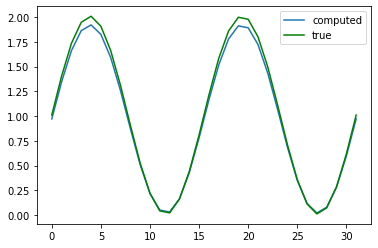

: 

In [42]:
%matplotlib inline

plt.semilogy(nn,err[:,0],'.-')
slope = np.polyfit(np.log(nn),err[:,0],deg=1)[0]
plt.semilogy(nn,err[:,1],'.-')
plt.title("evolution of error")
plt.legend(['max-norm (slope='+str(slope)+")",'mean'])
plt.savefig("graphics/poisson_error.pdf")

#print(err)
print("integral of u:           ", np.sum(u) / n**3)
print("integral of uex:         ", np.sum(uex_vect) / n**3)
print("max-norm of the error:   ", np.max(np.abs(u-uex_vect)))
print("L1-norm of the error:   ", np.mean(np.abs(u-uex_vect)))
#print("residual 2-norm:        ", np.linalg.norm(res))

i= 5
plt.figure()
plt.title("computed u")
plt.contour(u[i,:,:])
plt.colorbar()

plt.figure()
plt.title("exact u")
plt.contour(uex_vect[i,:,:])
plt.colorbar()

plt.figure()
plt.title("error")
plt.pcolormesh((u-uex_vect)[i,:,:])
plt.colorbar()

plt.figure()
plt.plot(u[i,i,:])
plt.plot(uex_vect[i,i,:],"green")
plt.legend(["computed","true"])


In [35]:
%matplotlib
plt.figure()
s = plot_slider(u)

Using matplotlib backend: MacOSX


In [36]:
from BenamouBrenier import last_root
tt = np.linspace(-20,10,20)
alpha,beta= 1,1
f = lambda t: (alpha-0.5*t)*(1+0.5*t)**2 + 0.5*beta**2
a,b,c = 4-2*alpha, 4-8*alpha, 4*beta**2-8*alpha
g = lambda t: -(t**3 + a*t**2 + b*t + c)/8
plt.plot(tt,f(tt))
plt.plot(tt,g(tt))
plt.plot(last_root(a,b,c),0,'o') 